In [34]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                              username = "root",
                              password = "chiruyadav3377",
                              database = "ecommerce")

cur = db.cursor()

# 1. List all unique cities where customers are located.

In [31]:
query = """SELECT customer_city, COUNT(*) as city_count 
           FROM customers 
           GROUP BY customer_city 
           ORDER BY city_count DESC 
           LIMIT 5"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame (data, columns = ['customer_city','no_of_customers'])
df


,customer_city,no_of_customers
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521


# 2. Count the number of orders placed in 2017.

In [13]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

" total orders placed in 2017",data[0][0]

(' total orders placed in 2017', 45101)

# 3. Find the total sales per category.

In [24]:
query = """select products.product_category_name as category, round(sum(payments.payment_value),2)  as sales 
from products join order_items on products.product_id = order_items.product_id 
join payments on payments.order_id = order_items.order_id
group by category """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame (data, columns = ['category',' sales'])
df

,category,sales
0,sport leisure,1392127.56
1,Garden tools,838280.75
2,Cool Stuff,779698.00
3,Furniture Decoration,1430176.39
4,perfumery,506738.66
...,...,...
69,House Comfort 2,1710.54
70,cds music dvds,1199.43
71,flowers,2213.01
72,Arts and Crafts,2326.17


# 4. Count the number of customers from each state. 

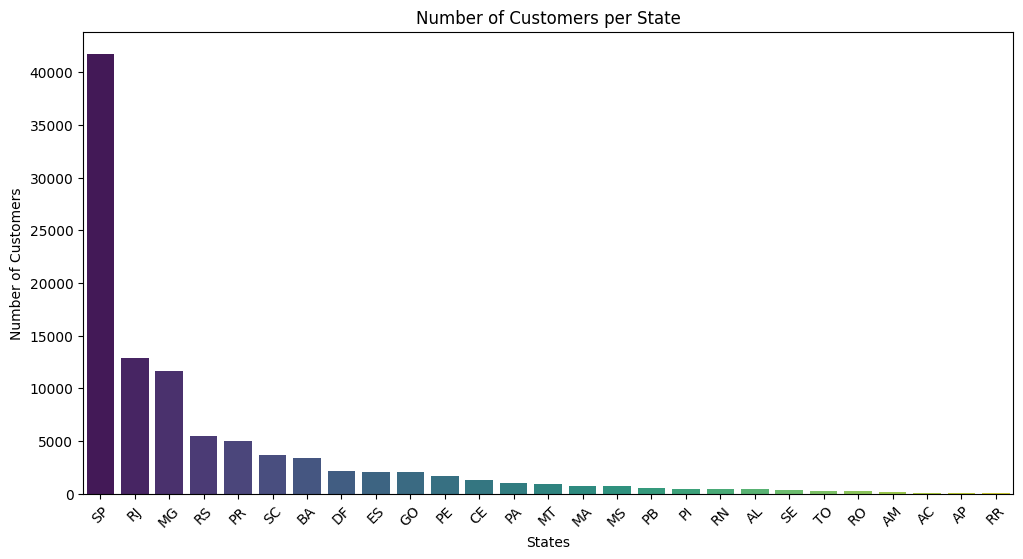

In [8]:
query = """select customer_state, count(customer_id) from customers group by customer_state """

cur.execute(query)

data = cur.fetchall()
data

df = pd.DataFrame (data,columns = ['customer_state','no_of_customers'])
df

df = df.sort_values(by="no_of_customers", ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x="customer_state", y="no_of_customers", hue="customer_state", data=df, palette="viridis", legend=False)


plt.xlabel("States")
plt.ylabel("Number of Customers")
plt.title("Number of Customers per State")
plt.xticks(rotation=45) 

plt.show()


# 5. Calculate the number of orders per month in 2018.

In [7]:
query = """select monthname(order_purchase_timestamp) as months,  count(order_id) as order_count from orders where year(order_purchase_timestamp) = 2018
group by months """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['months','total_orders'])
df

,months,total_orders
0,January,7269
1,August,6512
2,July,6292
3,March,7211
4,February,6728
5,April,6939
6,May,6873
7,June,6167
8,September,16
9,October,4


# 6. Find the average number of products per order, grouped by customer city.

In [2]:
query = """with count_per_order as (select orders.customer_id, orders.order_id, count(order_items.order_id) as orders
from orders join order_items on orders.order_id = order_items.order_id 
group by orders.customer_id, orders.order_id)
select customers.customer_city as customer_city , round(avg(count_per_order.orders),2) as avg_order
from customers join count_per_order on customers.customer_id = count_per_order.customer_id
group by customer_city order by avg_order desc; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame (data, columns = ['customer_city','avg_per_order'])
df.head(10)

,customer_city,avg_per_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,teixeira soares,4.00
6,morro de sao paulo,4.00
7,picarra,4.00
8,cidelandia,4.00
9,curralinho,4.00


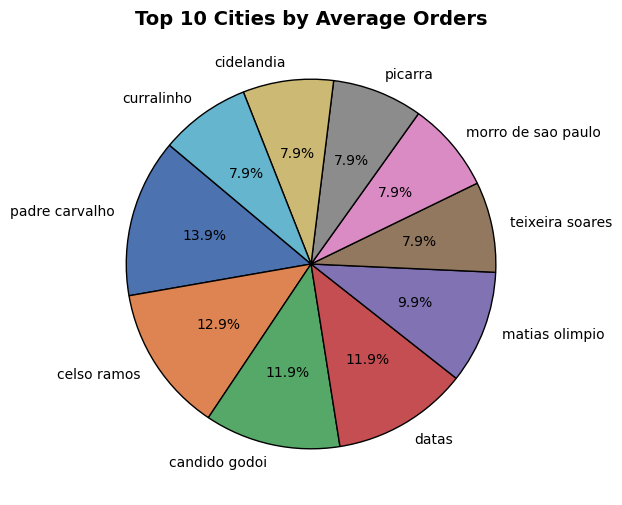

In [12]:
df["avg_per_order"] = pd.to_numeric(df["avg_per_order"], errors="coerce")

df_top10 = df.nlargest(10, "avg_per_order")

colors = sns.color_palette("deep")  

plt.figure(figsize=(6, 6))
plt.pie(df_top10["avg_per_order"], labels=df_top10["customer_city"], autopct="%1.1f%%", 
        colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Top 10 Cities by Average Orders", fontsize=14, fontweight='bold')

plt.show()

# 7. Calculate the percentage of total revenue contributed by each product category.

In [37]:
query = """select upper(products.product_category_name) as category, round((sum(payments.payment_value) / (select sum(payment_value) from payments)*100),2) as sales
from products join order_items on products.product_id = order_items.product_id 
join payments on payments.order_id = order_items.order_id 
group by category
 order by sales desc;  """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['product_category','sales_%'])
df.head(10)

,product_category,sales_%
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


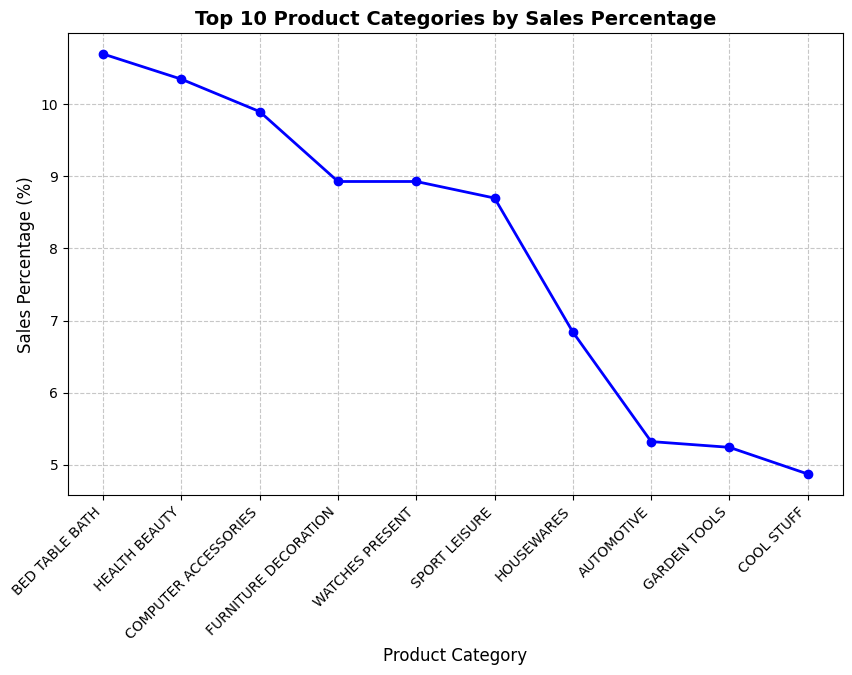

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(df_top10["product_category"], df_top10["sales_%"], marker="o", linestyle="-", color="b", linewidth=2)

plt.xlabel("Product Category", fontsize=12)
plt.ylabel("Sales Percentage (%)", fontsize=12)
plt.title("Top 10 Product Categories by Sales Percentage", fontsize=14, fontweight="bold")

plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# 8. Identify the correlation between product price and the number of times a product has been purchased.

In [50]:
query = """select products.product_category_name as category, count(order_items.product_id)  , round(avg(order_items.price),2) 
from products join order_items on products.product_id = order_items.product_id
group by category""" ;
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['category','order_count','price'])
df

,category,order_count,price
0,Cool Stuff,3796,167.36
1,pet Shop,1947,110.07
2,Furniture Decoration,8334,87.56
3,perfumery,3419,116.74
4,Garden tools,4347,111.63
...,...,...,...
69,Fashion Sport,30,70.65
70,La Cuisine,14,146.78
71,PC Gamer,9,171.77
72,insurance and services,2,141.64


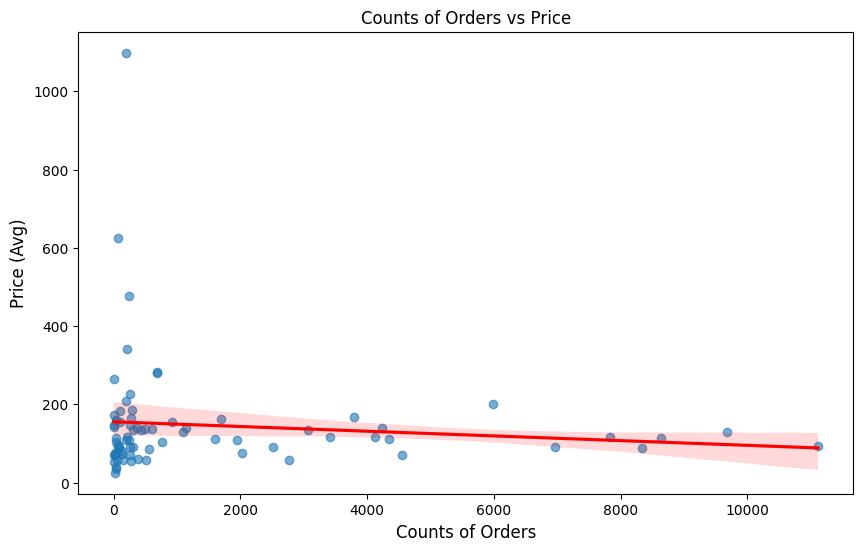

In [51]:
plt.figure(figsize=(10, 6))
sns.regplot(x="order_count", y="price", data=df, scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})
plt.xlabel("Counts of Orders", fontsize=12)
plt.ylabel("Price (Avg)", fontsize=12)
plt.title('Counts of Orders vs Price')
plt.show()

# Conclusion:
# The weak negative correlation suggests that price is not a strong factor in determining order count.

# 9. Calculate the total revenue generated by each seller, and rank them by revenue.

In [24]:
query = """ select * , dense_rank() over(order by revenue desc) as seller_rank  from 
(select order_items.seller_id as seller_id, sum(payments.payment_value) as revenue 
from order_items join payments on payments.order_id = order_items.order_id 
group by seller_id) as A""" ;
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame (data, columns = ['seller_id','total_revenue','seller_rank'])
df.head(10)

,seller_id,total_revenue,seller_rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.319315,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.120939,7
7,955fee9216a65b617aa5c0531780ce60,236322.300502,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.229870,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.209706,10


# 10. Calculate the moving average of order values for each customer over their order history.

In [6]:
query = """ select customer_id, order_purchase_timestamp, payment, 
round(avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row), 5)
as moving_avg 
from   
  (select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment 
from payments join orders on payments.order_id = orders.order_id ) as a""" ;
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame (data, columns = ['customer_id','purchase_date','price','moving_avg'])
df

,customer_id,purchase_date,price,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74000
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41000
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42000
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35001
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01000
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,9.49,27.12000
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13000
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13000
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50000


# 11. Calculate the cumulative sales per month for each year.

In [55]:
query = """select years, months, payments ,round(sum(payments) over(order by years,months),2)
as cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years, 
 month(orders.order_purchase_timestamp) as months,
 round(sum(payments.payment_value),2) as payments
from orders join payments on orders.order_id = payments.order_id 
group by years, months order by years, months) as a """ ;

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame (data, columns = ['years','months','sales','cumulative_sales'])
df

,years,months,sales,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


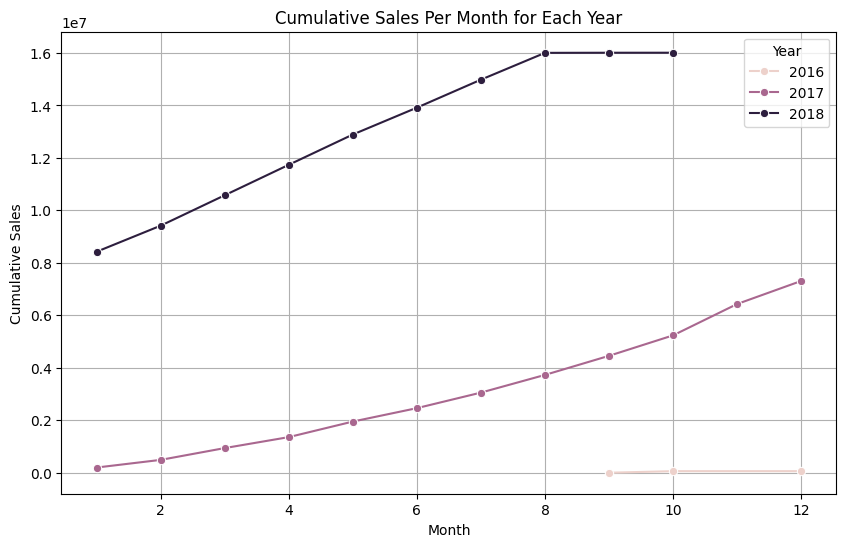

In [56]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['months'], y=df['cumulative_sales'], hue=df['years'], marker='o')
plt.xlabel('Month')
plt.ylabel('Cumulative Sales')
plt.title('Cumulative Sales Per Month for Each Year')
plt.legend(title='Year')
plt.grid('true')

plt.show()

# 12. Calculate the year-over-year growth rate of total sales.

In [58]:
query = """with a as (select year(orders.order_purchase_timestamp) as years, 
round(sum(payments.payment_value),2) as payments
from orders join payments on orders.order_id = payments.order_id 
group by years order by years) 

select years, round((payments - lag(payments,1) over(order by years)) / lag(payments,1) over(order by years) *100,4)
from a """ ;

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['years','year_over_year_growth_%'])
df

,years,year_over_year_growth_%
0,2016,NaN
1,2017,12112.7038
2,2018,20.0009
